# Creating a functional recommender system in Python

In this notebook we'll create a recommender system a few different ways.  We will build a **content filtering recommender**, a **collaborative filtering recommender**, and **matrix factorization recommender using alternating least squares**

There is no one size fits all recommender, so this will cover multiple scenarios

## Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('data/u.data', sep='\t', names=header)

In [3]:
movies_titles = pd.read_csv('Data/ml-latest-small/movies.csv')
movies_titles.columns = ['item_id','title', 'genre']

In [4]:
# Merge dataframes
df = pd.merge(ratings,movies_titles,on='item_id')

## Do Some Exploratory Analysis

In [5]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()
avg_rating = round(df.rating.mean(),2)
print('Num. of Users: '+ str(n_users))
print('Num. of Movies: '+str(n_items))
print('Average User-Movie Rating: '+str(avg_rating))
print "Average Reviewers Per Movie: %r"%(round(df.groupby(['title','item_id'])['rating'].count().mean(),2))

Num. of Users: 943
Num. of Movies: 1344
Average User-Movie Rating: 3.55
Average Reviewers Per Movie: 62.68


In [6]:
# Sample Row
ratings.head(1)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949


In [7]:
# Sample Row
movies_titles.head(1)

,item_id,title,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [8]:
# Sample Row
df.head(1)

,user_id,item_id,rating,timestamp,title,genre
0,196,242,3,881250949,Farinelli: il castrato (1994),Drama|Musical


In [9]:
# Average Rating - Movie
mean_ratings = pd.DataFrame(df.groupby(['title','item_id','genre'])['rating'].mean())
mean_ratings = mean_ratings.reset_index()

# Number of Reviews - Movie
ratings_count = pd.DataFrame(df.groupby(['title','item_id'])['rating'].count())
ratings_count = ratings_count.reset_index()

# New Dataframe
ratings = pd.merge(ratings_count, mean_ratings, on='item_id')
ratings.columns = ['title','item_id','number of ratings','title2','genres','rating']
del ratings['title2']

In [10]:
# Movies with most ratings
pd.DataFrame(df.groupby('title')['rating'].count().sort_values(ascending=False).head())

,rating
title,
"Usual Suspects, The (1995)",583
"Kid in King Arthur's Court, A (1995)",509
City Hall (1996),508
Mighty Morphin Power Rangers: The Movie (1995),507
"Perez Family, The (1995)",485


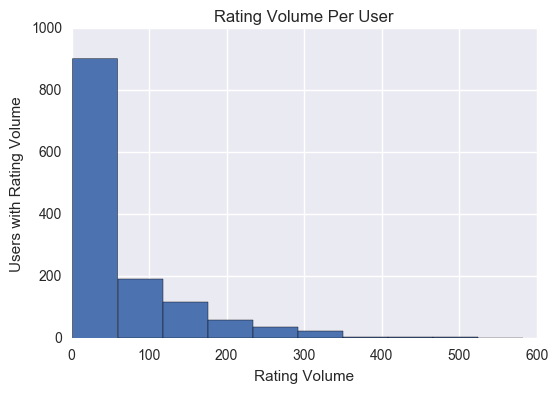

In [11]:
# Ratings Count histogram
ratings['number of ratings'].hist(bins = 10)
plt.title('Rating Volume Per User')
plt.xlabel('Rating Volume')
plt.ylabel('Users with Rating Volume')

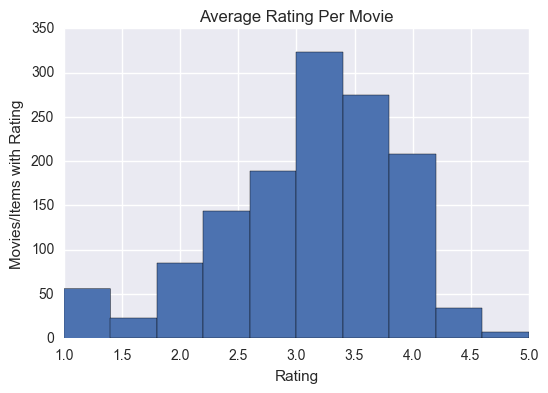

In [12]:
# Average Rating histogram
ratings['rating'].hist(bins = 10)
plt.title('Average Rating Per Movie')
plt.xlabel('Rating')
plt.ylabel('Movies/Items with Rating')

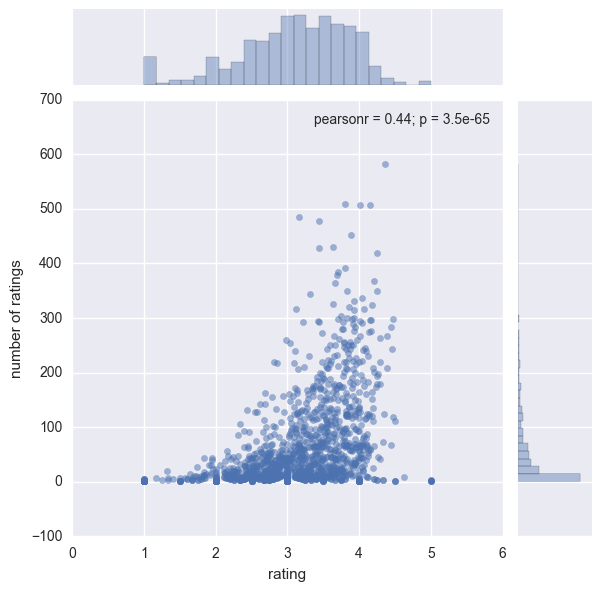

In [13]:
sns.jointplot(x='rating',y = 'number of ratings', data= ratings,alpha = 0.5)

In [14]:
# Let's Split Genres and check that out
genres = ratings.set_index('item_id')['genres'].str.get_dummies(sep='|') 

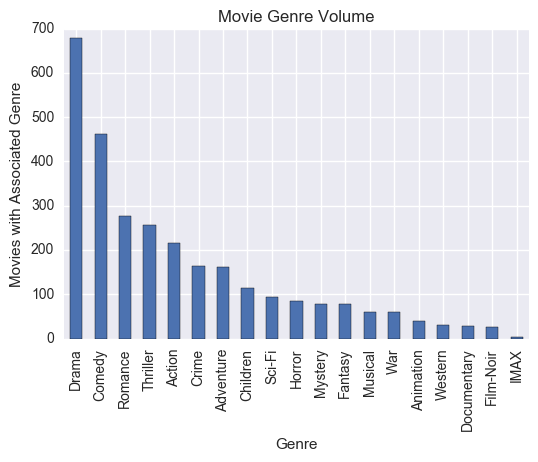

In [15]:
genres.sum().sort_values(ascending = 0).plot(kind='bar')
plt.title('Movie Genre Volume')
plt.xlabel('Genre')
plt.ylabel('Movies with Associated Genre')

## Recommending Similar Movies - Content Filtering Algorithm

Let's add our genre dataframe back to our ratings

In [16]:
ratings = pd.merge(ratings, genres.reset_index(), on='item_id')

We don't need the genre column anymore, since we split that categorical variable out.  We don't need item_id either because we aren't using it as our key anymore

In [17]:
content_ratings = ratings
del content_ratings['genres']

In [18]:
del content_ratings['item_id']
content_ratings.head(2)

,title,number of ratings,rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,'Til There Was You (1997),31,2.548387,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,101 Dalmatians (1996),5,4.200000,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's scale the rating and mean rating columns so that we assume they are centered around zero and have variance in the same order

In [19]:
scaler = MinMaxScaler()
content_ratings[['number of ratings', 'rating']] = scaler.fit_transform(content_ratings[['number of ratings', 'rating']])

In [20]:
content_ratingsT = content_ratings.T
content_ratingsT.columns = content_ratings.T.iloc[0]
content_ratingsT = content_ratingsT.drop(content_ratingsT.index[0])

In [21]:
movies_dict = content_ratingsT.to_dict()

Example of what a row looks like

In [22]:
# movies_dict['Toy Story (1995)']
movies_dict.items()[1000]

('Wild America (1997)',
 {'Action': 0,
  'Adventure': 1,
  'Animation': 0,
  'Children': 1,
  'Comedy': 0,
  'Crime': 0,
  'Documentary': 0,
  'Drama': 0,
  'Fantasy': 0,
  'Film-Noir': 0,
  'Horror': 0,
  'IMAX': 0,
  'Musical': 0,
  'Mystery': 0,
  'Romance': 0,
  'Sci-Fi': 0,
  'Thriller': 0,
  'War': 0,
  'Western': 0,
  'number of ratings': 0.0,
  'rating': 0.0})

Pearson Similarity
* The Pearson correlation computes the mean of the product of mean adjusted random variables.
* It is defined as the covariance of two variables (movie1 and movie2, in our case) divided by the product of the standard deviation of movie1 and the standard deviation of movie1.
* The closer the score is to 1, the more ratings they have in common

In [23]:
def sim_pearson(prefs, movie1,movie2):
    si={}
    for item in prefs[movie1]:
        if item in prefs[movie2]:
            si[item] = 1
    n = len(si)
    
    # If they have no rankings in common, return 0.
    if len(si) == 0:
        return 0
    
    # Loop through each movie once and 
    # compute the required components for our final calculation.
    sum1 = sum2 = sum1Sq = sum2Sq = pSum = 0
    
    # Let's get the sum of all of the ratings for movie1 and movie2
    sum1 = sum([prefs[movie1][item] for item in si])
    sum2 = sum([prefs[movie2][item] for item in si])
    
    # Now let's get the sum of all of the ratings squared
    sum1Sq = sum([pow(prefs[movie1][item],2) for item in si])
    sum2Sq = sum([pow(prefs[movie2][item],2) for item in si])
    
    # This is the sum product of the ratings of our two movies
    pSum = sum([prefs[movie1][item]*prefs[movie2][item] for item in si])
    
    # Calculate Pearson Score
    num = pSum - (sum1*sum2/n)
    den = sqrt((sum1Sq - pow(sum1,2)/n)*(sum2Sq - pow(sum2,2)/n))

    # Prevent division by zero.
    if den == 0:
        return 0

    return abs(num / den)

In [24]:
sim_pearson(movies_dict, 'Toy Story (1995)', 'Cool Runnings (1993)')

0.42684570764512797

Helper function to return the top recommendations for a given movie

In [25]:
def topMatches(prefs,movie, n=10, similarity=sim_pearson):
    scores = [(similarity(prefs,movie,other),other) for other in prefs if other!= movie]
    
    scores.sort()
    scores.reverse()
    return scores[0:n]

In [26]:
# Let's see the top 20 movies / neighbors associated with Home Alone using Pearson Correlation
topMatches(movies_dict, 'Home Alone (1990)', n=20)

[(0.9997242725064994, 'House Arrest (1996)'),
 (0.9996534807118829, 'Little Rascals, The (1994)'),
 (0.9994681991965149, 'Harriet the Spy (1996)'),
 (0.999027497027373, 'Jungle2Jungle (a.k.a. Jungle 2 Jungle) (1997)'),
 (0.9989679210383121, 'First Kid (1996)'),
 (0.997173987731843, 'Richie Rich (1994)'),
 (0.9952962915870482, 'Love Bug, The (1969)'),
 (0.9923162201583996, 'Big Green, The (1995)'),
 (0.9922733180541358, 'George of the Jungle (1997)'),
 (0.9875967084513598, 'Air Bud (1997)'),
 (0.9861260767208694, 'D3: The Mighty Ducks (1996)'),
 (0.9847773915639799, 'Shaggy Dog, The (1959)'),
 (0.9826920862944838, 'Angels in the Outfield (1994)'),
 (0.9740637701806091, 'Heavyweights (Heavy Weights) (1995)'),
 (0.9738893787613863, 'Dunston Checks In (1996)'),
 (0.9547647690358585, 'Jingle All the Way (1996)'),
 (0.803179412660362, 'That Darn Cat! (1965)'),
 (0.8026774262337036, 'Herbie Rides Again (1974)'),
 (0.8026519875869981, 'Wallace & Gromit: A Close Shave (1995)'),
 (0.802611217092

## Recommending with Collaborative Filtering
* **Item-Item Collaborative Filtering**: “Users who liked this item also liked …”
    * This approach will take a particular item, find users who liked that item, and find other items that those users or similar users also liked.
* **User-Item Collaborative Filtering**: “Users who are similar to you also liked …”
    * This approach will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked.

## Item-Item Collaborative Filtering - Recommending Similar Movies

* Here we're going to create a matrix that has user_id as rows on the y axis, movie_title as columns on the X axis, and the rating that the user gave to that movie as each cell value.

* Note: The data is sparse and therefore we will see many NaN values since most people haven't seen most movies


In [27]:
movieMatrix = df[['user_id','title','rating']]

In [28]:
movieMatrix = movieMatrix.pivot_table(index='user_id',columns='title',values='rating')

#### First Approach - Pearson
* Let's use Pandas corrwith() method to get correlations between two pandas series:
    * Corrwith uses the Pearson Correlation as well, nicely packaged in the Pandas library
* To make a recommendation for one movie, we calculate a rating of others weighted by the similarity. 

In [33]:
ratings_sim = pd.merge(ratings_count, mean_ratings, on='item_id')
ratings_sim.columns = ['title','item_id','number of ratings','title2','genres','rating']
ratings_sim = ratings_sim.set_index('title')

In [29]:
movie1_user_ratings = movieMatrix['Home Alone (1990)']
movie2_user_ratings = movieMatrix['Pulp Fiction (1994)']

In [30]:
similar_to_movie1 = movieMatrix.corrwith(movie1_user_ratings)

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [31]:
corr_movie1 = pd.DataFrame(similar_to_movie1, columns=['Correlation'])
corr_movie1.dropna(inplace=True)

In [34]:
corr_movie1 = corr_movie1.join(ratings_sim['number of ratings'])

In [35]:
# Similar Movies to Home Alone (1990)
corr_movie1[corr_movie1['number of ratings']>50].sort_values('Correlation',ascending=False).head(10)

,Correlation,number of ratings
title,,
"Philadelphia Story, The (1940)",1.000000,58
"Island of Dr. Moreau, The (1996)",1.000000,59
Miracle on 34th Street (1994),1.000000,71
Short Cuts (1993),1.000000,54
Stuart Saves His Family (1995),1.000000,80
Ghost in the Shell (Kôkaku kidôtai) (1995),0.944911,58
Roommates (1995),0.942809,149
Spellbound (1945),0.872872,57
Castle Freak (1995),0.866025,66


In [36]:
# Dissimilar Movies (Since .57 is the 2nd closest correlation and thus not super strong)
corr_movie1[corr_movie1['number of ratings']>50].sort_values('Correlation',ascending=True).head(10)

,Correlation,number of ratings
title,,
Nothing to Lose (1994),-1.000000,53
Made in America (1993),-1.000000,52
Hot Shots! Part Deux (1993),-1.000000,52
Citizen Kane (1941),-1.000000,58
"Quick and the Dead, The (1995)",-1.000000,134
Ready to Wear (Pret-A-Porter) (1994),-1.000000,87
"Little Princess, A (1995)",-1.000000,66
Larger Than Life (1996),-0.960769,56
Pie in the Sky (1996),-0.942809,129


Not the best, let's try using Cosine similarity

#### Second Approach - Cosine

* We'll use the cosine similarity distance metric this time and it will answer the question:
    * Movie A is rated by X amount of users
* Then we'll find our user's interests similarities 
* This will allow us to make a system which recommends movies our user likes based on what they have previously rated.

In [37]:
movie_dict = movieMatrix.to_dict()

In [39]:
# movie_dict.keys()[0:10] # Shows the keys (in this case the movies)
# movie_dict.values()[0] # Shows just the values (in this case the ratings)
movie_dict.items()[0] # Shows the key and values for a certain index

('Adventures of Pinocchio, The (1996)',
 {1: nan,
  2: nan,
  3: nan,
  4: nan,
  5: nan,
  6: nan,
  7: nan,
  8: nan,
  9: nan,
  10: nan,
  11: nan,
  12: nan,
  13: 1.0,
  14: nan,
  15: nan,
  16: nan,
  17: nan,
  18: nan,
  19: nan,
  20: nan,
  21: nan,
  22: nan,
  23: nan,
  24: nan,
  25: nan,
  26: nan,
  27: nan,
  28: nan,
  29: nan,
  30: nan,
  31: nan,
  32: nan,
  33: nan,
  34: nan,
  35: nan,
  36: nan,
  37: nan,
  38: nan,
  39: nan,
  40: nan,
  41: nan,
  42: nan,
  43: nan,
  44: nan,
  45: nan,
  46: nan,
  47: nan,
  48: nan,
  49: nan,
  50: nan,
  51: nan,
  52: nan,
  53: nan,
  54: nan,
  55: nan,
  56: nan,
  57: nan,
  58: nan,
  59: nan,
  60: nan,
  61: nan,
  62: nan,
  63: 1.0,
  64: nan,
  65: nan,
  66: nan,
  67: nan,
  68: nan,
  69: nan,
  70: nan,
  71: nan,
  72: nan,
  73: nan,
  74: nan,
  75: nan,
  76: nan,
  77: nan,
  78: nan,
  79: nan,
  80: nan,
  81: nan,
  82: nan,
  83: 3.0,
  84: nan,
  85: nan,
  86: nan,
  87: nan,
  88: nan,
 

In [40]:
def cos_similarity(prefs,movie1,movie2):
    si={}
    for item in prefs[movie1]:
        if item in prefs[movie2]:
            si[item]=1
    # If they have no rankings in common, return 0.
    if len(si)==0:
        return 0
    sum1 = sum21 = sum22  =0

    for item in si:
        sum1+=(prefs[movie1][item]*prefs[movie2][item])
        sum21+=pow(prefs[movie1][item],2)
        sum22+=pow(prefs[movie2][item],2)
    if sum21==0 or sum22==0:
        return 0

    return round(sum1/(sqrt(sum21)*sqrt(sum22)),2)

In [41]:
userMatrix = movieMatrix.T

In [42]:
user_dict = movieMatrix.T.to_dict()

In [44]:
user1Ratings = userMatrix[200]

In [45]:
user1RatingsDf = pd.DataFrame(user1Ratings)
user1RatingsDf.columns = ['Rating']
user1RatingsDf = user1RatingsDf.reset_index().sort_values(by = 'Rating', ascending = False).set_index('title')

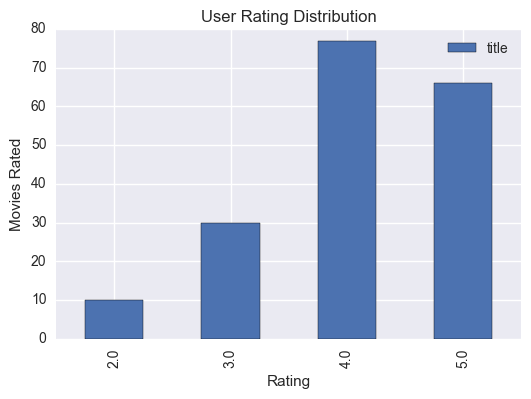

In [55]:
user1RatingsDf.reset_index().groupby('Rating').count().plot(kind = 'bar')
plt.title('User Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Movies Rated')

In [57]:
user1RatingsDf.head() # Top Ratings 

,Rating
title,
2001: A Space Odyssey (1968),5.0
"Juror, The (1996)",5.0
Mr. Holland's Opus (1995),5.0
Milk Money (1994),5.0
"Man of No Importance, A (1994)",5.0


In [58]:
ratings_sim = ratings_sim.reset_index()

Let's filter down our data set to include movies that our user has seen that have had at least 50 reviews in total

In [59]:
movies_seen = list(user1RatingsDf[~user1RatingsDf['Rating'].isnull()].reset_index().sort_values(by = 'Rating', ascending = False)['title'])

Now let's combine that with the rest of the movie rating dataset and filter down to include only those with 50 ratings

50 is arbitrary, we could have used mean, median, or if we wanted to ensure large amounts of data we could have gone above a standard deviation or more.

Frozenset (seen below) allows us to keep the order of our user ratings after we intersect

In [61]:
# movies_seen.intersection(ratings_sim[ratings_sim['title']])
set_2 = frozenset(ratings_sim[ratings_sim['number of ratings'] > 50]['title']) # frozenset keeps the order of 
intersection = [x for x in movies_seen if x in set_2]


In [62]:
movies_seen = intersection

In [65]:
movies_seen

['2001: A Space Odyssey (1968)',
 'Beverly Hills Cop III (1994)',
 'Speechless (1994)',
 'Space Jam (1996)',
 'Something to Talk About (1995)',
 'Shawshank Redemption, The (1994)',
 'Secret Adventures of Tom Thumb, The (1993)',
 'Scarlet Letter, The (1995)',
 'Roommates (1995)',
 'Remains of the Day, The (1993)',
 'Persuasion (1995)',
 'Flirting With Disaster (1996)',
 "Young Poisoner's Handbook, The (1995)",
 'Blown Away (1994)',
 'Cabin Boy (1994)',
 'Dolores Claiborne (1995)',
 'Destiny Turns on the Radio (1995)',
 'Total Eclipse (1995)',
 "City Slickers II: The Legend of Curly's Gold (1994)",
 'Circle of Friends (1995)',
 'Basketball Diaries, The (1995)',
 'Drop Zone (1994)',
 "Carlito's Way (1993)",
 'Bhaji on the Beach (1993)',
 'Broken Arrow (1996)',
 'Endless Summer 2, The (1994)',
 'Boys of St. Vincent, The (1992)',
 'Aladdin (1992)',
 'Boys on the Side (1995)',
 "Antonia's Line (Antonia) (1995)",
 'American President, The (1995)',
 'Juror, The (1996)',
 'Swan Princess, The (1

This is a knob we can turn to return movies that meet the threshold criteria instead of something like 'Top 10'

In [66]:
threshold=0.98
# threshold = .5

This code computes a cosine similarity score for each movie our user has seen against every other movie that meets our criteria.


In [67]:
recommended_list = []
# moviepair = []
for movie1 in movies_seen:
    print "| "+movie1+" |"
    print "----------"
#     movies = []
    for movie2 in sorted(movie_dict.keys()):
        movietuple = []
        if movie1 == movie2:
            continue
        try:
            #We're only going to show films that have at least 50 ratings
            if movie1 in movies_seen and ratings_sim[ratings_sim['title'] == movie2]['number of ratings'].values >50:
                result=cos_similarity(movies_dict, movie1, movie2)
                if result>=threshold:
#                     print movie2 +"\t",result
                    movietuple.append(movie1)
                    movietuple.append(movie2)
                    movietuple.append(result)
                    recommended_list.append(movietuple)
        except:
            pass
#     print "----------"

| 2001: A Space Odyssey (1968) |
----------
| Beverly Hills Cop III (1994) |
----------
| Speechless (1994) |
----------
| Space Jam (1996) |
----------
| Something to Talk About (1995) |
----------
| Shawshank Redemption, The (1994) |
----------
| Secret Adventures of Tom Thumb, The (1993) |
----------
| Scarlet Letter, The (1995) |
----------
| Roommates (1995) |
----------
| Remains of the Day, The (1993) |
----------
| Persuasion (1995) |
----------
| Flirting With Disaster (1996) |
----------
| Young Poisoner's Handbook, The (1995) |
----------
| Blown Away (1994) |
----------
| Cabin Boy (1994) |
----------
| Dolores Claiborne (1995) |
----------
| Destiny Turns on the Radio (1995) |
----------
| Total Eclipse (1995) |
----------
| City Slickers II: The Legend of Curly's Gold (1994) |
----------
| Circle of Friends (1995) |
----------
| Basketball Diaries, The (1995) |
----------
| Drop Zone (1994) |
----------
| Carlito's Way (1993) |
----------
| Bhaji on the Beach (1993) |
---

We now have the pairwise similarity scores for every movie our user has seen and every other movie that fits the criteria (50 ratings).  Let's put it into a dataframe and check out the recommendations

In [68]:
recommended_list = pd.DataFrame(recommended_list)
recommended_list.columns = ['Seen','Recommended','Similarity']

Return the movies not already seen by our user

In [69]:
recommended_list = recommended_list[~recommended_list['Recommended'].isin(movies_seen)]

In [79]:
movies_seen_rank = pd.DataFrame(movies_seen).reset_index()
movies_seen_rank.columns = ['rank','title']

In [81]:
recommended_list.columns = ['title','Recommended','Similarity']
recommended_list = pd.merge(recommended_list, movies_seen_rank, on='title', how='left')
recommended_list.columns = ['Seen','Recommended','Similarity','Rank']

In [95]:
recommended_list.sort(['Rank','Seen','Similarity'],ascending=[True,True,False]).groupby('Seen').head(5)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Seen,Recommended,Similarity,Rank
0,Speechless (1994),Barcelona (1994),1.00,2
2,Speechless (1994),Clueless (1995),1.00,2
3,Speechless (1994),Englishman Who Went Up a Hill But Came Down a ...,1.00,2
7,Speechless (1994),Mr. Wonderful (1993),1.00,2
8,Speechless (1994),Much Ado About Nothing (1993),1.00,2
19,Something to Talk About (1995),Waiting to Exhale (1995),1.00,4
18,Something to Talk About (1995),Nobody's Fool (1994),0.99,4
16,Something to Talk About (1995),Eat Drink Man Woman (Yin shi nan nu) (1994),0.98,4
17,Something to Talk About (1995),Mighty Aphrodite (1995),0.98,4
20,"Shawshank Redemption, The (1994)","Hate (Haine, La) (1995)",1.00,5


## Collaborative Filtering - Matrix Factorization using Alternating Least Squares

This type of model is similar to the one that won the Netflix prize.

We're going to create a rating matrix in which each rating can be looked at as a weighted linear combination of latent user and movie factors 

To get a rating, we're going to take the dot product of the corresponding user vector row and the corresponding movie vector column

Before we had one big matrix of shape Users x Movies

Now we have 2 matrices:
* Users x k latent features 
* Movies x k latent features
    
When multiplied the k cancels out and we still end up with one big matrix that is User x Movies shape

We don't actually know k, but that's the trick of alternating least squares
* We randomly initialize our movie matrix, then estimate the user matrix (for every user).
    * We'll initialize with average ratings for each movie in our user matrix and then random numbers elsewhere
* This will allow us to then go back and estimate the movie matrix (for every movie).
    * When we estimate the movie matrix, we use the same steps
* This happens until we minimized our cost, convergence, and find a solid approximation of the whole ratings matrix. 
    * Turns our problem into a least squares problem and solving for that system.
    
  

In [112]:
import numpy as np
import pandas as pd
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('data/u.data', sep='\t', names=header)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print 'Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)

Number of users = 943 | Number of movies = 1682


Split into test train groups and then get our matrices built. They're essentially pivot tables with rows as uses, columns as item, and value as rating

In [113]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df,test_size=0.25)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Create training and test matrix
R = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3]  

T = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]

* Now let's create a matrix that'll be 1 if there's a rating and 0 if it's not rated
* It'll help us out more later when we want to estimate parameters since we're just doing it for those without ratings

In [114]:
# Index matrix for our training_data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for our test_data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

* To evaluate our recommender, let's use the RMSE
* The cost function / loss function that we want to minimize is therefore the sum of squared errors

In [115]:
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R > 0]))

And now for ALS
* We need to define hyperameters as below and then create the latent user matrix, followed by the latent movie matrix.  Then we need to get the average rating for each movie, and set up our kxk matrix placeholder which we will update

In [116]:
lmbda = 0.1 # Regularization wt
k = 20 # Latent Features
n_iterations = 15 # Number of iterations
m, n = R.shape # Number of users and items/movies
P = 3 * np.random.rand(k,m) # Latent user matrix - 3 chosen because it's the middle in our rating system
Q = 3 * np.random.rand(k,n) # Latent movie matrix
Q[0,:] = R[R != 0].mean(axis=0) # Average rating for each movie
E = np.eye(k) # (k x k)-dimensional identity matrix

In [117]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_iterations):
    # Fill Q and estimate P
    # Fill the latent MOVIE matrix and estimate the latent USER matrix
    for i, Ii in enumerate(I):
        # Number of items User i has rated
        nui = np.count_nonzero(Ii)
        
        # Zero counts break the algorithm and make a singular vector which we can't have
        if (nui == 0): nui = 1 
    
        # Our ALS solution
        ####
        # Latent Movie Matrix x Transpose of Latent Movie Matrix
        # + our regularization component 
        # * the number of movies the user has seen
        # * the dimensionality shape that we need
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        # Latent Movie Matrix x Transpose of Training Data Matrix
        Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        
        # Update P by Multiplying Matrices
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    # Fix the latent user matrix and estimate the latent movie matrix
    for j, Ij in enumerate(I.T):
        # Number of users that rated item j
        nmj = np.count_nonzero(Ij)
        # Be aware of zero counts, they break the algorithm
        # and make it singular 
        if (nmj == 0): nmj = 1
        
        # Our ALS solution
        ####
        # Latent User Matrix x Transpose of Latent User Matrix
        # + our regularization component 
        # * the number of users the movie has been reviewed by
        # * the dimensionality shape that we need
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
        
        # Update Q by Multiplying Matrices
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    # Finally we just need to store our errors to eventually analyze them
    train_rmse = rmse(I,R,Q,P)
    test_rmse = rmse(I2,T,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print "[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_iterations, train_rmse, test_rmse)
    
print "Algorithm converged"

[Epoch 1/15] train error: 1.170163, test error: 1.279174
[Epoch 2/15] train error: 0.871669, test error: 1.057317
[Epoch 3/15] train error: 0.783613, test error: 1.014481
[Epoch 4/15] train error: 0.742314, test error: 0.992886
[Epoch 5/15] train error: 0.718831, test error: 0.979059
[Epoch 6/15] train error: 0.703957, test error: 0.969506
[Epoch 7/15] train error: 0.693809, test error: 0.962636
[Epoch 8/15] train error: 0.686509, test error: 0.957561
[Epoch 9/15] train error: 0.681058, test error: 0.953737
[Epoch 10/15] train error: 0.676877, test error: 0.950803
[Epoch 11/15] train error: 0.673599, test error: 0.948510
[Epoch 12/15] train error: 0.670980, test error: 0.946683
[Epoch 13/15] train error: 0.668850, test error: 0.945202
[Epoch 14/15] train error: 0.667092, test error: 0.943979
[Epoch 15/15] train error: 0.665621, test error: 0.942954
Algorithm converged


Let's plot the learning curve now

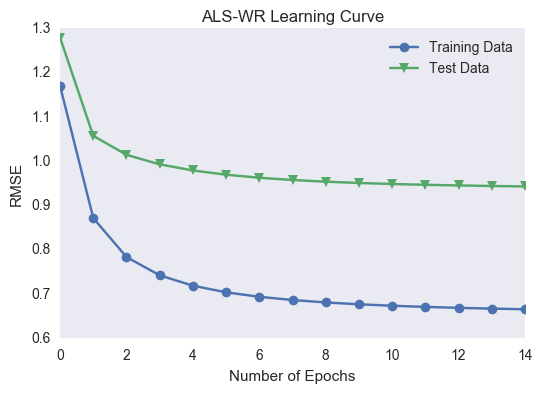

In [118]:
plt.plot(range(n_iterations), train_errors, marker='o', label='Training Data');
plt.plot(range(n_iterations), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

Since both Train and Test decrease and converge over time, instead of the test error increasing for instance, suggests that we're not overfitting

To improve the model even more I would implement a grid search to optimize parameters.  These were chosen at random.

Ok Cool, now that we have error analysis to support our model, let's recommend some movies

In [119]:
# Calculate R_pred prediction matrix (low-rank approximation for R)
R_hat = pd.DataFrame(np.dot(P.T,Q))
R = pd.DataFrame(R)

In [132]:
user = 500

In [149]:
# Compare true ratings of user 200 with predictions
ratings = pd.DataFrame(data=R.loc[user-1,R.loc[user-1,:] > 0])
ratings['Prediction'] = R_hat.loc[user-1,R.loc[user-1,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']

In [150]:
ratings.head(n=10)

,Actual Rating,Predicted Rating
0,4.0,3.199344
2,4.0,3.331617
6,5.0,3.936925
8,4.0,3.899629
12,5.0,3.723377
14,2.0,3.069626
15,4.0,3.540107
24,3.0,3.292060
27,3.0,3.222838
29,4.0,3.847497


In [151]:
ratings['difference'] = abs(ratings['Actual Rating']- ratings['Predicted Rating'])

In [152]:
ratings['difference'].mean()

0.5848226850140352

Not bad.  The model seems to have performed pretty well in terms of figuring out the user's rating profile.

So now let's recommend

In [167]:
predictions = R_hat.loc[user-1,R.loc[user-1,:] == 0] 
predictions = predictions.sort_values(ascending=False)
recommendations = pd.DataFrame(data=predictions)
recommendations.columns = ['Predicted Rating']


In [168]:
recommendations

,Predicted Rating
1448,4.331953
1121,4.320326
55,4.306713
59,4.270375
511,4.262367
168,4.241784
1130,4.225328
113,4.213844
653,4.204751
1366,4.188338


In [169]:
print R_hat.shape
print R_hat.loc[user-1,R.loc[user-1,:] != 0].shape
print predictions.shape

(943, 1682)
(168,)
(1514,)


In [170]:
not_seen = movies_titles[movies_titles['item_id'].isin((recommendations.index))]

In [171]:
recommendations = recommendations.reset_index()
recommendations.columns = ['item_id','Predicted Rating']

In [172]:
recommendations = pd.merge(recommendations,not_seen, on='item_id')
recommendations = recommendations.set_index('item_id')

In [173]:
# Movies Seen
movies_titles[movies_titles['item_id'].isin(df[df['user_id'] == user]['item_id'])].head(5)

,item_id,title,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action


In [176]:
# Movie Recommendations for our user
recommendations[recommendations['Predicted Rating'] > 4]

,Predicted Rating,title,genre
item_id,,,
1121,4.320326,Glory Daze (1995),Drama
55,4.306713,Georgia (1995),Drama
59,4.270375,"Confessional, The (Confessionnal, Le) (1995)",Drama|Mystery
511,4.262367,"Program, The (1993)",Action|Drama
168,4.241784,First Knight (1995),Action|Drama|Romance
1130,4.225328,"Howling, The (1980)",Horror|Mystery
113,4.213844,Before and After (1996),Drama|Mystery
653,4.204751,Dragonheart (1996),Action|Adventure|Fantasy
1366,4.188338,"Crucible, The (1996)",Drama
